## Comparison of face reconstruction and random face generation using
1.    a plain autoencoder,
2.   a variational autoencoder.



In [2]:
# COLABORATORY CELL ONLY:

# Load the Drive helper and mount:
from google.colab import drive

# This will prompt for authorization:
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# COLABORATORY CELL ONLY:

# Make your Google Drive directory your present working directory:
%cd drive/My\ Drive


/content/drive/My Drive


In [0]:
# COLABORATORY CELL ONLY:

# "git clone" our "variational-autoencoder" repo into your Google Drive (this only needs to be done once):
# # !git clone https://github.com/smflores1/variational-autoencoder.git


In [4]:
# COLABORATORY CELL ONLY:

# Make the "variational-autoencoder" repo your present working directory:
%cd variational-autoencoder

# Pull the latest version of the repo:
!git pull origin master


/content/drive/My Drive/variational-autoencoder
From https://github.com/smflores1/variational-autoencoder
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Import the following packages, for use throughout:

import os
import numpy as np
from PIL import Image
import utils.utils as utils
from matplotlib import pyplot as plt
from variational_autoencoder import VariationalAutoencoder

%matplotlib inline


In [0]:
# Data, constants, and functions for use throughout this notebook:

PROJECT_NAME = 'celebA'
DEFAULT_MODEL_NAME = PROJECT_NAME + '_model'

IMAGE_NUM = 151
NUM_SUBPLOTS = 11

def get_feature_direction(VAE, feature_images_dict, feature, num_images):
    
#   Get the vector in the latent space that points in the direction of a particular feature.
    
    assert feature in feature_images_dict
    
    with_feature_index_list = feature_images_dict[feature]
    wout_feature_index_list = [i for i in range(num_images) if i not in feature_images_dict[feature]]
    
    cutoff = min(1000, len(with_feature_index_list), len(wout_feature_index_list))
    
    with_feature = np.mean(VAE.encode(IMAGE_ARRAY[with_feature_index_list[:cutoff]])[0], axis = 0)
    wout_feature = np.mean(VAE.encode(IMAGE_ARRAY[wout_feature_index_list[:cutoff]])[0], axis = 0)
    
    return with_feature - wout_feature


In [7]:
# More data and constants for use throughout this notebook.

# This cell will pickle and save a large numpy array with NUM_IMAGES x 64 x 64 x 3 images,
# with each image containing the cropped face. The final file could be over 1GB.
# File structure must be as follows in order for this cell to run:
#     root
#       |--variational_autoencoder.py
#       |--constants.py
#       |utils
#       |   |--utils.py
#       |
#       |--celebA
#           |--data
#               |--list_attr_celeba.txt (can be found at "http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html")
#               |--img_align_celeba (can be found at "http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html")
#                         |--000001.jpg (image 1 of a face)
#                         |--000002.jpg (image 2 of a face)
#                         |--000003.jpg (image 3 of a face)
#                         |--etc.
# You might also need to change the value of 'PATH_FACEDATA' in 'constants.py' to match your installation of OpenCV.

NUM_IMAGES = 15000

IMAGES_NAME = 'img_align_celeba' # Directory containing all face images to be processed ('.jpg' only).
ATTRIB_NAME = 'list_attr_celeba.txt' # File containing face attribute annotations.
PICKLE_NAME = PROJECT_NAME + '_' + str(NUM_IMAGES) # Name of the pickled file with images of the cropped faces.
DETAIL_NAME = PICKLE_NAME + '_details' # Name of the pickled file with a dictionary of face attribute annotations.

# Pickle and save a numpy array with NUM_IMAGES x 64 x 64 x 3 images, each image containing the cropped face.
# The final file could be over 1GB:
utils.get_cropped_faces(PROJECT_NAME, IMAGES_NAME, PICKLE_NAME, ATTRIB_NAME, NUM_IMAGES)

# celebA image data, shaped to NUM_IMAGES x 64 x 64 x 3 images (altogether a 4-tensor) with values from 0 to 255. 
IMAGE_ARRAY, FEATURES_IMAGES_DICT = utils.load_data(PROJECT_NAME, PICKLE_NAME)
print('Input data shape:', IMAGE_ARRAY.shape)
    
INPUT_X = IMAGE_ARRAY.shape[1] # x dimension of input images,
INPUT_Y = IMAGE_ARRAY.shape[2] # y dimension of input images,
INPUT_Z = IMAGE_ARRAY.shape[3] # z dimension (three, images are RGB).

INPUTS_SHAPE_LIST = [INPUT_X, INPUT_Y, INPUT_Z]


Input data shape: (15000, 64, 64, 3)


### Create a plain autoencoder and a variational autoencoder, and check out its properties.

In [0]:
# Create a new autoencoder model and a new variational autoencoder model:

# Encoder architecture:
encoder_list = [{'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [256], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [100]}]

# Decoder architecture:
decoder_list = [{'layer_type': 'full_cn', 'output_shape': [4 * 4 * 256], 'activation': 'relu'},
                {'layer_type': 'reshape', 'output_shape': [4, 4, 256]},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [3],   'pool_shape': [2, 2], 'activation': 'sigmoid'}]

# Dictionary of all details needed to specify a new model:
model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'loss_type': 'pixel',
                      'encoder_loss_weight': 1.0,
                      'decoder_loss_weight': 1.0,
                      'learning_rate': 0.001}

# Create a new autoencoder model:
model_details_dict['is_variational'] = False # A variational autoencoder.
with VariationalAutoencoder(model_details_dict) as VAE:
    
    _ae_model_name = VAE.model_name
    
# Create a new variational autoencoder model:
model_details_dict['is_variational'] = True # A variational autoencoder.
with VariationalAutoencoder(model_details_dict) as VAE:
    
    vae_model_name = VAE.model_name


In [17]:
# Print out the shape of each layer in the autoencoder model created in the previous cell:

model_details_dict = {'project_name': PROJECT_NAME,
                      'model_name': _ae_model_name}
    
with VariationalAutoencoder(model_details_dict) as VAE:
    
    print('Layer shapes for the (variational) autoencoder:\n')
    
    print('Inputs shape:\n', VAE.inputs_shape, '\n')

    print('Encoder shape list:')
    for item in VAE.encoder_shape_list:
        print(item)
    print('\n')
    
    print('Latent shape:\n', VAE.latent_shape, '\n')
    
    print('Decoder shape list:')
    for item in VAE.decoder_shape_list:
        print(item)
    print('\n')
    
    print('Output shape:\n', VAE.output_shape, '\n')
    
    print('Altogether, the layer shape list for the entire (variational) autoencoder:')
    for item in VAE.layer_shape_list:
        print(item)
   


Layer shapes for the (variational) autoencoder:

Inputs shape:
 [64 64  3] 

Encoder shape list:
[64 64  3]
[32 32 32]
[16 16 64]
[  8   8 128]
[  4   4 256]
[4096]
[100]


Latent shape:
 [100] 

Decoder shape list:
[100]
[4096]
[  4   4 256]
[  8   8 128]
[16 16 64]
[32 32 32]
[64 64  3]


Output shape:
 [64 64  3] 

Altogether, the layer shape list for the entire (variational) autoencoder:
[64 64  3]
[32 32 32]
[16 16 64]
[  8   8 128]
[  4   4 256]
[4096]
[100]
[4096]
[  4   4 256]
[  8   8 128]
[16 16 64]
[32 32 32]
[64 64  3]


In [16]:
# Check out the computational graph of either model in tensorboard:

model_details_dict = {'project_name': PROJECT_NAME}

# Create the tensorboard visualization for either model:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name
    
    with VariationalAutoencoder(model_details_dict) as VAE:
        
        print('Here is the graph for the {} (model_name = "{}"):\n'.format(model_type, model_name))
        VAE.show_graph()

Here is the graph for the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



Here is the graph for the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111"):



### Train both the plain autoencoder and the variational autoencoder on the celebA dataset.

In [18]:
# Train both the plain autoencoder and the variational autoencoder on the image data:

model_details_dict = {'project_name': PROJECT_NAME}

# Train the models:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name
    
    with VariationalAutoencoder(model_details_dict) as VAE:
    
        print('Start training the {} (model_name = "{}"):\n'.format(model_type, model_name))
        VAE.train_model(IMAGE_ARRAY, batch_size = 40, num_training_epochs = 30, display_step = 5)
        print('\nDone training the {} (model_name = "{}").\n'.format(model_type, model_name))


Start training the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



Epoch 5 of 30 completed. Total time elapsed so far: 49.852
----------------------------------------------------------
Loss over all input data: 6458.889
Time to train last epoch: 10.148


Epoch 10 of 30 completed. Total time elapsed so far: 100.001
------------------------------------------------------------
Loss over all input data: 6412.994
Time to train last epoch: 9.865


Epoch 15 of 30 completed. Total time elapsed so far: 149.655
------------------------------------------------------------
Loss over all input data: 6392.672
Time to train last epoch: 9.924


Epoch 20 of 30 completed. Total time elapsed so far: 199.521
------------------------------------------------------------
Loss over all input data: 6379.361
Time to train last epoch: 9.912


Epoch 25 of 30 completed. Total time elapsed so far: 249.174
------------------------------------------------------------
Loss over all input

### Compare face reconstruction capabilities of the plain autoencoder and the variational autoencoder.

Face reconstruction using the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



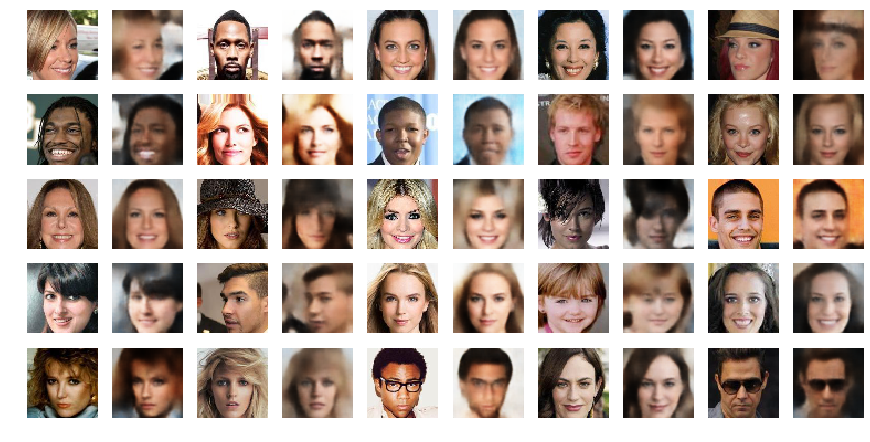

Face reconstruction using the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111"):



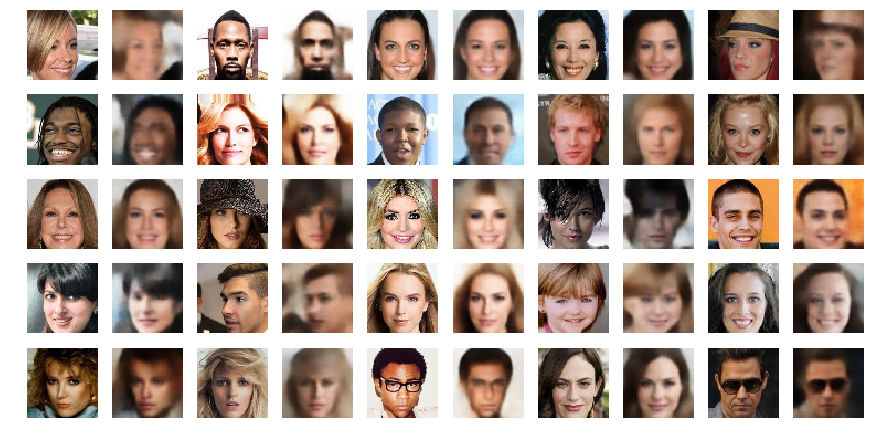

In [21]:
# Face reconstruction for the plain autoencoder and for the variational autoencoder:

model_details_dict = {'project_name': PROJECT_NAME}

# Get face reconstructions for either model:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name
    
    with VariationalAutoencoder(model_details_dict) as VAE:
    
        print('Face reconstruction using the {} (model_name = "{}"):\n'.format(model_type, model_name))
    
        num_rows = 5
        num_cols = 5

        plt.subplots(num_rows, 2 * num_cols, figsize = (15, 7.5))

        for i in range(num_rows):
            for j in range(num_cols):

                input_image = IMAGE_ARRAY[num_cols * i + j: num_cols * i + j + 1]

                faked_image = VAE.reform(input_image)

                for k, image in enumerate([input_image, faked_image]):

                    plt.subplot(num_rows, 2 * num_cols, i * 2 * num_cols + 2 * j + k + 1)
                    plt.imshow(image[0])
                    plt.axis('off')

        plt.show()


Side-by-side comparison of face reconstructions:
  -Columns 1, 4, 7, etc. have the original image.
  -Columns 2, 5, 8, etc. have image reconstructions that use the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235").
  -Columns 3, 6, 9, etc. have image reconstructions that use the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111").



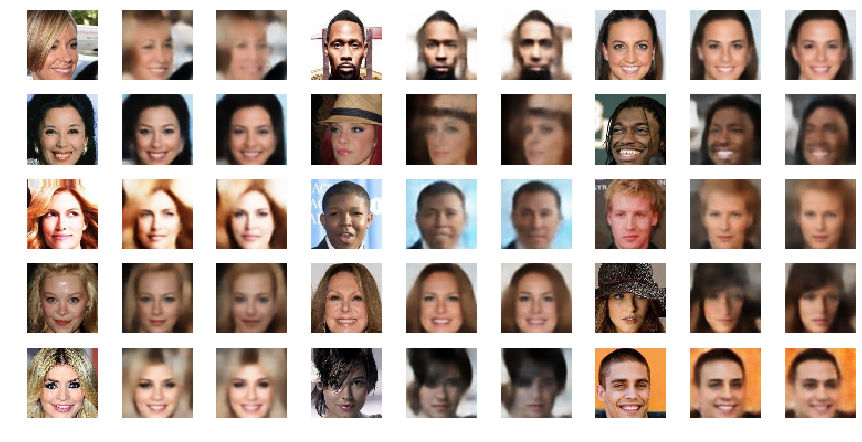

In [29]:
# Compare face reconstructions of both models side-by-side:

# Plain autoencoder:
_ae_model_details_dict = {'project_name': PROJECT_NAME,
                          'model_name': _ae_model_name}

# Variational autoencoder:
vae_model_details_dict = {'project_name': PROJECT_NAME,
                          'model_name': vae_model_name}

# Create the face reconstructions
print('Side-by-side comparison of face reconstructions:')
print('  -Columns 1, 4, 7, etc. have the original image.')
print('  -Columns 2, 5, 8, etc. have image reconstructions that use the plain autoencoder (model_name = "{}").'.format(_ae_model_name))
print('  -Columns 3, 6, 9, etc. have image reconstructions that use the variational autoencoder (model_name = "{}").\n'.format(vae_model_name))
with VariationalAutoencoder(_ae_model_details_dict) as _AE, VariationalAutoencoder(vae_model_details_dict) as VAE:
    
    num_rows = 5
    num_cols = 3
    
    plt.subplots(num_rows, 3 * num_cols, figsize = (15, 7.5))
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            input_image = IMAGE_ARRAY[num_cols * i + j: num_cols * i + j + 1]
            
            _ae_faked_image = _AE.reform(input_image)
            vae_faked_image = VAE.reform(input_image)
            
            for k, image in enumerate([input_image, _ae_faked_image, vae_faked_image]):

                plt.subplot(num_rows, 3 * num_cols, i * 3 * num_cols + 3 * j + k + 1)
                plt.imshow(image[0])
                plt.axis('off')
        
    plt.show()


### Compare face generation capabilities of the plain autoencoder and the variational autoencoder.

Face generation using the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



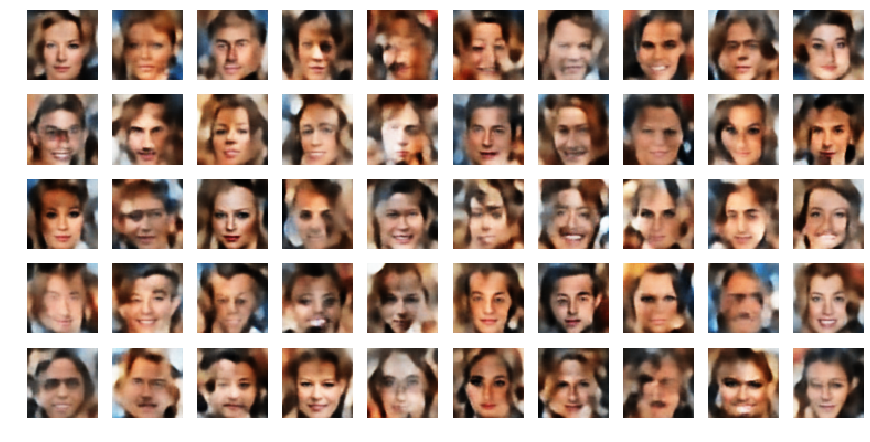

Face generation using the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111"):



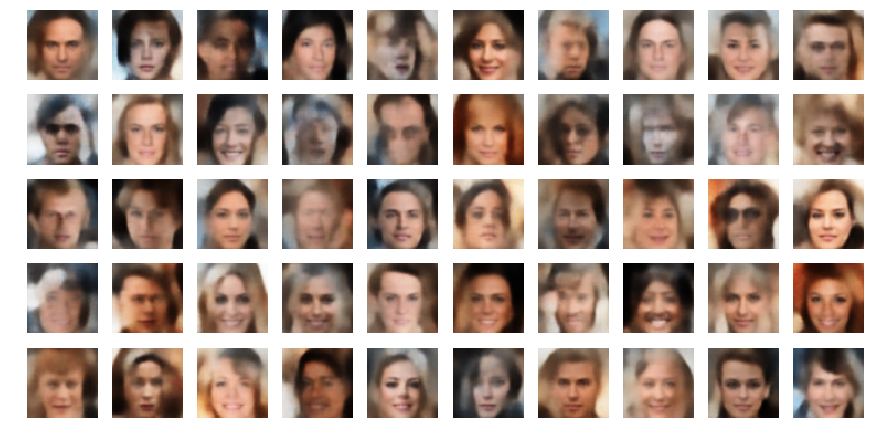

In [35]:
# Face generation for the plain autoencoder and for the variational autoencoder:

model_details_dict = {'project_name': PROJECT_NAME}

# Get face reconstructions for either model:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name
    
    with VariationalAutoencoder(model_details_dict) as VAE:
        
        print('Face generation using the {} (model_name = "{}"):\n'.format(model_type, model_name))
        
        if model_type == 'plain autoencoder':
            means = np.expand_dims(np.mean(VAE.encode(IMAGE_ARRAY)[0], axis = 0), axis = 0)
            stdev = np.expand_dims(np.std( VAE.encode(IMAGE_ARRAY)[0], axis = 0), axis = 0)
        else:
            assert model_type == 'variational autoencoder'
            means = np.zeros([1, *VAE.latent_shape])
            stdev = np.ones( [1, *VAE.latent_shape])
    
        num_rows = 5
        num_cols = 10

        plt.subplots(num_rows, num_cols, figsize = (15, 7.5))

        for i in range(num_rows):
            for j in range(num_cols):

                latent_vector = stdev * np.random.randn(*VAE.latent_shape) + means

                faked_image = VAE.decode(latent_vector)

                plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
                plt.imshow(faked_image[0])
                plt.axis('off')

        plt.show()

### Compare face feature interpolation capabilities of the plain autoencoder and the variational autoencoder.

Gradually changing hair color using the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



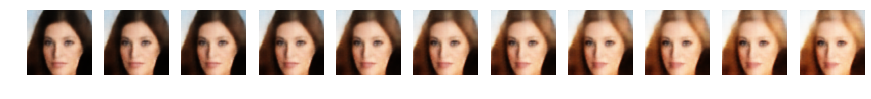

Gradually changing hair color using the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111"):



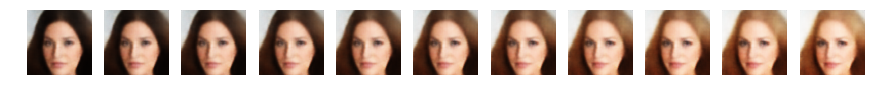

In [37]:
# Gradually convert hair color from brown or black to blond:

feature = 'Blond_Hair'
assert feature in FEATURES_IMAGES_DICT
assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature]

model_details_dict = {'project_name': PROJECT_NAME}

# Convert hair color using either model:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name

    with VariationalAutoencoder(model_details_dict) as VAE:
        
        print('Gradually changing hair color using the {} (model_name = "{}"):\n'.format(model_type, model_name))

    #   Encode the original face:
        wout_feature_sample = VAE.encode(IMAGE_ARRAY[IMAGE_NUM: IMAGE_NUM + 1])[0]

    #   Get the vector that points in the direction of 'feature':
        feature_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature, len(IMAGE_ARRAY))

        plt.subplots(1, NUM_SUBPLOTS, figsize = (15, 15))

        for i in range(NUM_SUBPLOTS):

    #       Add increasing multiplies of 'feature_delta' to superimpose 'feature' onto the original image:
            with_feature_sample = wout_feature_sample + feature_delta * (3 * i / (NUM_SUBPLOTS - 1))

            plt.subplot(1, NUM_SUBPLOTS, i + 1)
            plt.imshow(VAE.decode(with_feature_sample)[0])
            plt.axis('off')

        plt.show()


Gradually adding sunglasses using the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



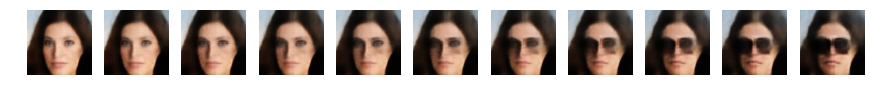

Gradually adding sunglasses using the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111"):



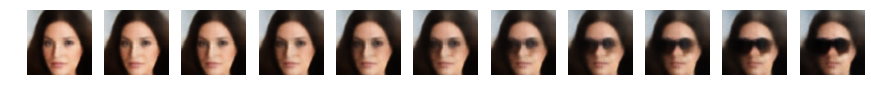

In [39]:
# Gradually add sunglasses to a face:

feature = 'Eyeglasses'
assert feature in FEATURES_IMAGES_DICT
assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature]

model_details_dict = {'project_name': PROJECT_NAME}

# Add sunglasses using either model:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name

    with VariationalAutoencoder(model_details_dict) as VAE:
        
        print('Gradually adding sunglasses using the {} (model_name = "{}"):\n'.format(model_type, model_name))

    #   Encode the original face:
        wout_feature_sample = VAE.encode(IMAGE_ARRAY[IMAGE_NUM: IMAGE_NUM + 1])[0]

    #   Get the vector that points in the direction of 'feature':
        feature_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature, len(IMAGE_ARRAY))

        plt.subplots(1, NUM_SUBPLOTS, figsize = (15, 15))

        for i in range(NUM_SUBPLOTS):

    #       Add increasing multiplies of 'feature_delta' to superimpose 'feature' onto the original image:
            with_feature_sample = wout_feature_sample + feature_delta * (4 * i / (NUM_SUBPLOTS - 1))

            plt.subplot(1, NUM_SUBPLOTS, i + 1)
            plt.imshow(VAE.decode(with_feature_sample)[0])
            plt.axis('off')

        plt.show()


Gradually adding sunglasses and changing hair color using the plain autoencoder (model_name = "celebA_model_2019-04-24T19-46-38.214235"):



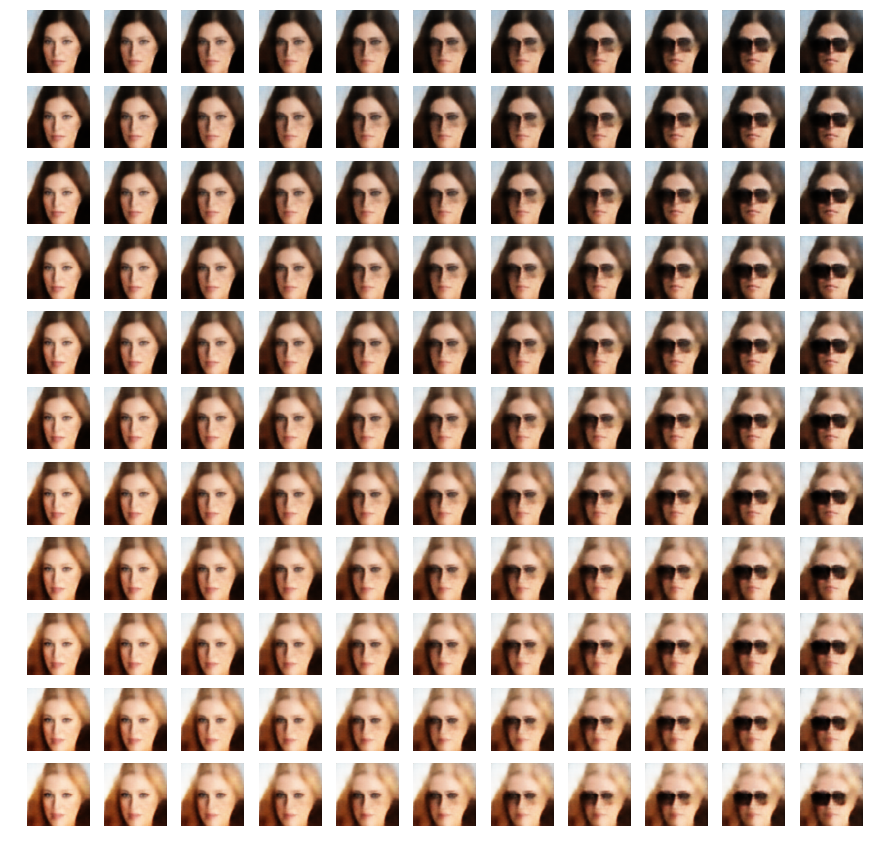

Gradually adding sunglasses and changing hair color using the variational autoencoder (model_name = "celebA_model_2019-04-24T19-46-39.742111"):



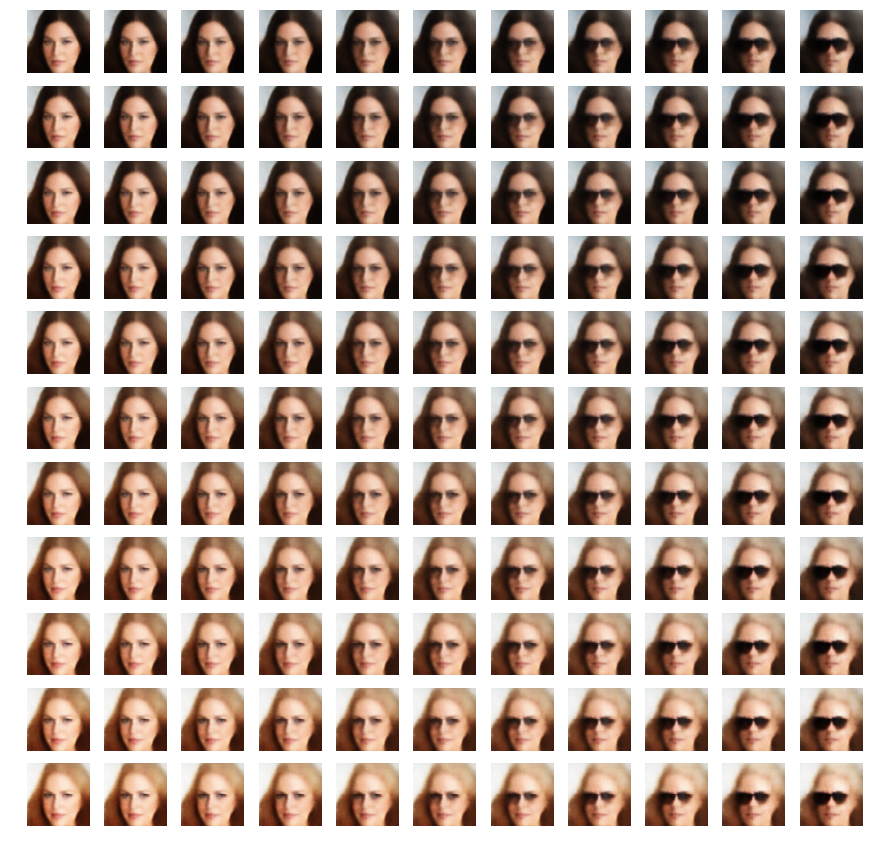

In [40]:
# Gradually add sunglasses to a face and change hair color too:

feature_1 = 'Blond_Hair'
feature_2 = 'Eyeglasses'

assert feature_1 in FEATURES_IMAGES_DICT
assert feature_2 in FEATURES_IMAGES_DICT

assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature_1]
assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature_2]

model_details_dict = {'project_name': PROJECT_NAME}

# Add sunglasses and change haircolor using either model:
for model_name, model_type in zip([_ae_model_name, vae_model_name], ['plain autoencoder', 'variational autoencoder']):
    
    model_details_dict['model_name'] = model_name
    
    print('Gradually adding sunglasses and changing hair color using the {} (model_name = "{}"):\n'.format(model_type, model_name))
    
    with VariationalAutoencoder(model_details_dict) as VAE:

    #   Encode the original face:
        wout_feature_sample = VAE.encode(IMAGE_ARRAY[IMAGE_NUM: IMAGE_NUM + 1])[0]

    #   Get the vectors that points in the direction of 'feature_1' and 'feature_2' respectively:
        feature_1_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature_1, len(IMAGE_ARRAY))
        feature_2_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature_2, len(IMAGE_ARRAY))

        plt.subplots(NUM_SUBPLOTS, NUM_SUBPLOTS, figsize = (15, 15))

        for i in range(NUM_SUBPLOTS):
            for j in range(NUM_SUBPLOTS):

    #           Add increasing multiplies of 'feature_delta_1' and 'feature_delta_2' to superimpose 
    #          'feature_1' and 'feature_2' onto the original image:
                with_feature_sample = wout_feature_sample + feature_1_delta * (3 * i / (NUM_SUBPLOTS - 1)) \
                                    + feature_2_delta * (4 * j / (NUM_SUBPLOTS - 1))

                plt.subplot(NUM_SUBPLOTS, NUM_SUBPLOTS, NUM_SUBPLOTS * i + j + 1)
                plt.imshow(VAE.decode(with_feature_sample)[0])
                plt.axis('off')

        plt.show()

